In [ ]:
#    LOGISTIC REGRESSION

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
heart_data = pd.read_csv("heart.csv")

# Splitting Features and Target
X = heart_data.drop(columns='target', axis=1)
Y = heart_data['target']

# Wrapper Method for Feature Selection using RFE
def select_features(X, Y, n_features=8):
    log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
    rfe = RFE(log_reg, n_features_to_select=n_features)
    X_selected = rfe.fit_transform(X, Y)
    selected_features = X.columns[rfe.support_]
    print("Selected Features:", list(selected_features))
    return X_selected

X_selected = select_features(X, Y)

# Split Data
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.3, stratify=Y, random_state=2)

# Define Objective Function for PSO (Minimizing Cross-Validation Error)
def objective_function(C_value):
    model = LogisticRegression(C=C_value, solver='liblinear', max_iter=1000)
    scores = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy')
    return -np.mean(scores)  # Minimize negative accuracy (maximize accuracy)

# Particle Swarm Optimization (PSO)
def pso(n_particles=10, n_iterations=20):
    np.random.seed(42)
    swarm = np.random.uniform(low=0.01, high=100, size=(n_particles, 1))
    velocities = np.random.uniform(low=-1, high=1, size=(n_particles, 1))
    personal_best = swarm.copy()
    personal_best_scores = np.array([objective_function(p[0]) for p in swarm])
    global_best = personal_best[np.argmin(personal_best_scores)]

    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            velocities[i] = 0.5 * velocities[i] + r1 * (personal_best[i] - swarm[i]) + r2 * (global_best - swarm[i])
            swarm[i] += velocities[i]
            swarm[i] = np.clip(swarm[i], 0.01, 100)
            score = objective_function(swarm[i][0])
            if score < personal_best_scores[i]:
                personal_best[i] = swarm[i]
                personal_best_scores[i] = score

        global_best = personal_best[np.argmin(personal_best_scores)]

    return global_best[0]

# Run PSO to find the best C
C_best = abs(pso(n_particles=10, n_iterations=20))
print(f"Optimized C value: {C_best}")

# Train Logistic Regression Model with optimized C
model_pso = LogisticRegression(C=C_best, solver='liblinear', max_iter=1000)
model_pso.fit(X_train, Y_train)

# Evaluate on training data
X_train_prediction_pso = model_pso.predict(X_train)
training_data_accuracy_pso = accuracy_score(Y_train, X_train_prediction_pso)
print('Accuracy on Training Data:', training_data_accuracy_pso)

# Evaluate on test data
X_test_prediction_pso = model_pso.predict(X_test)
test_data_accuracy_pso = accuracy_score(Y_test, X_test_prediction_pso)
print('Accuracy on Test Data:', test_data_accuracy_pso)

# Confusion Matrix & Classification Report
cm_pso = confusion_matrix(Y_test, X_test_prediction_pso)
print("Confusion Matrix:")
print(cm_pso)

report_pso = classification_report(Y_test, X_test_prediction_pso)
print("Classification Report:")
print(report_pso)

Selected Features: ['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Optimized C value: 8.104623093691966
Accuracy on Training Data: 0.8772663877266388
Accuracy on Test Data: 0.8051948051948052
Confusion Matrix:
[[112  38]
 [ 22 136]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       150
           1       0.78      0.86      0.82       158

    accuracy                           0.81       308
   macro avg       0.81      0.80      0.80       308
weighted avg       0.81      0.81      0.80       308



In [ ]:
#                                            SVM

Selected Features by RFE:
- sex
- cp
- restecg
- exang
- oldpeak
- slope
- ca
- thal

Best C from PSO: 0.0474

Train Accuracy: 0.8479776847977685
Test Accuracy: 0.8246753246753247

Confusion Matrix:
 [[112  38]
 [ 16 142]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       150
           1       0.79      0.90      0.84       158

    accuracy                           0.82       308
   macro avg       0.83      0.82      0.82       308
weighted avg       0.83      0.82      0.82       308



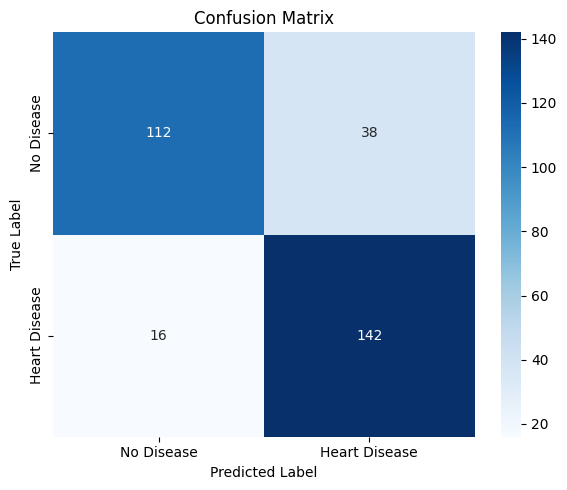

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
heart_data = pd.read_csv("heart.csv")

# Features and target
X = heart_data.drop(columns='target', axis=1)
Y = heart_data['target']
feature_names = X.columns

# Feature selection using RFE
def select_features(X, Y, n_features=8):
    svm = SVC(kernel='linear', C=1)
    rfe = RFE(svm, n_features_to_select=n_features)
    rfe.fit(X, Y)
    selected_features = X.columns[rfe.support_]
    X_selected = rfe.transform(X)
    return X_selected, selected_features, rfe

X_selected, selected_features, rfe_model = select_features(X, Y, n_features=8)

# Print selected features
print("Selected Features by RFE:")
for feature in selected_features:
    print("-", feature)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.3, stratify=Y, random_state=42)

# PSO objective function
def objective_function(C_value):
    model = SVC(C=C_value, kernel='linear')
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
    return -np.mean(scores)

# PSO implementation
def pso(n_particles=20, n_iterations=30):
    np.random.seed(42)
    swarm = np.random.uniform(low=0.01, high=5, size=(n_particles, 1))
    velocities = np.random.uniform(low=-1, high=1, size=(n_particles, 1))
    personal_best = swarm.copy()
    personal_best_scores = np.array([objective_function(p[0]) for p in swarm])
    global_best = personal_best[np.argmin(personal_best_scores)]

    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            velocities[i] = 0.5 * velocities[i] + r1 * (personal_best[i] - swarm[i]) + r2 * (global_best - swarm[i])
            swarm[i] += velocities[i]
            swarm[i] = np.clip(swarm[i], 0.01, 5)
            score = objective_function(swarm[i][0])
            if score < personal_best_scores[i]:
                personal_best[i] = swarm[i]
                personal_best_scores[i] = score

        global_best = personal_best[np.argmin(personal_best_scores)]

    return global_best[0]

# Run PSO to get best C
C_best = abs(pso())
print(f"\nBest C from PSO: {C_best:.4f}")

# Train final model
model = SVC(C=C_best, kernel='linear')
model.fit(X_train, Y_train)

# Predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Evaluation
print("\nTrain Accuracy:", accuracy_score(Y_train, train_pred))
print("Test Accuracy:", accuracy_score(Y_test, test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, test_pred))
print("\nClassification Report:\n", classification_report(Y_test, test_pred))

# Plot Confusion Matrix
cm = confusion_matrix(Y_test, test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Heart Disease'],
            yticklabels=['No Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Predict for a new person (output: positive/negative)
def predict_for_new_person(model, rfe_model, selected_features):
    # Fill this dict based on selected features
    example_values = {
        'cp': 2,
        'thalach': 150,
        'exang': 0,
        'oldpeak': 1.5,
        'slope': 2,
        'ca': 0,
        'thal': 2,
        'restecg': 1
    }

    # Ensure only selected features are used
    new_data = pd.DataFrame([example_values])[list(selected_features)]
    new_input = rfe_model.transform(new_data)
    prediction = model.predict(new_input)

   
    if prediction[0] == 1:
        print("\nHeart Disease: Positive ✅")
    else:
        print("\nHeart Disease: Negative ❌")


